## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [144]:
## Basic libraries
import sys, os, array, time
import numpy as np
import matplotlib.pyplot as plt
import IPython
import pandas as pd
import seaborn as sns

## MLP model related libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

## Datasets and validation output libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

## Dataset balancing libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

**QUESTION:** Load dataset and display some lines of the csv file.

In [145]:
## Importation of the dataset
Dataset = open("ai4i2020.csv", "r").readlines()
Data_names = Dataset.pop(0).split(",")
Data_names[0] = "UDI"
Data_names[-1] = "RNF"

## Printing some values to understand how the dataset is organised
print(Data_names)
print(Dataset[0])
print(Dataset[99])
print(Dataset[9999])

['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0

100,L47279,L,298.8,308.8,1523,44.4,55,0,0,0,0,0,0

10000,M24859,M,299.0,308.7,1500,40.2,30,0,0,0,0,0,0



**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

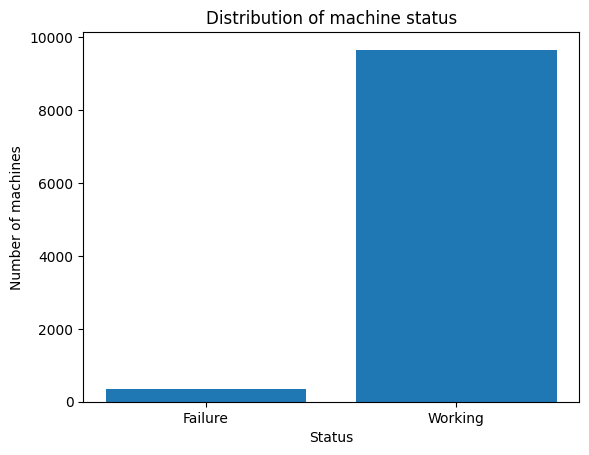

Number of failures :  339


In [146]:
## Initialisation
usable_dataset = []
State = ["Failure", "Working"]
Number_Failure = [0,0]

## Computation of the machine status
for l in Dataset :
    A = l.split(",")
    B = A[-1].split("\n")
    A.pop(-1)
    A.append(B[0])
    usable_dataset.append(A)
    if (A[8] == "0") :
        Number_Failure[1] += 1
    else :
        Number_Failure[0] += 1

## Plotting of the machine status
plt.figure(1)
plt.bar(State, Number_Failure)
plt.title('Distribution of machine status')
plt.xlabel('Status')
plt.ylabel('Number of machines')
plt.show()
print("Number of failures : ", Number_Failure[0])

**ANALYSIS QUESTION:** What do you observe?

_There are few exemples of failures in the dataset, and a lot of working machines_

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

_The model will "forget" about the failed machines and learn the parameters that implie that a machine is working_

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

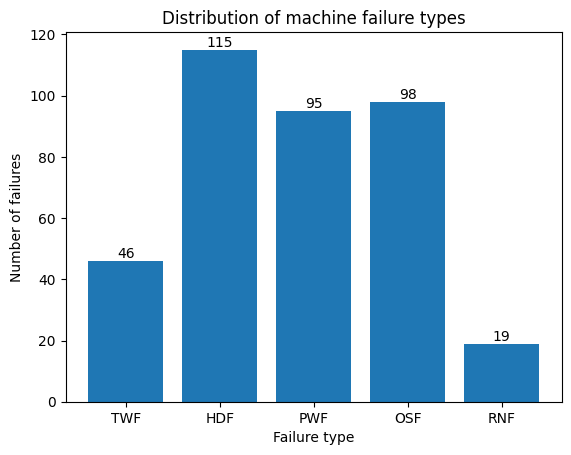

In [147]:
## Initialisation
failure_type = ["TWF", "HDF", "PWF", "OSF", "RNF"]
failure_type_nb = [0, 0, 0, 0, 0]

## Computation of the failures types
for l in usable_dataset :
    if (l[9] == "1") :
        failure_type_nb[0] += 1
    if (l[10] == "1") :
        failure_type_nb[1] += 1
    if (l[11] == "1") :
        failure_type_nb[2] += 1
    if (l[12] == "1") :
        failure_type_nb[3] += 1
    if (l[13] == "1") :
        failure_type_nb[4] += 1

## Plotting of the different kind of failures 
plt.figure(2)
plt.bar(failure_type, failure_type_nb)
plt.title('Distribution of machine failure types')
plt.xlabel('Failure type')
plt.ylabel('Number of failures')
for i, value in enumerate(failure_type_nb):
    plt.text(i, value+1, str(value), ha='center')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

_"We can see that failures are mainly due to temperature, power or overstress"_

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

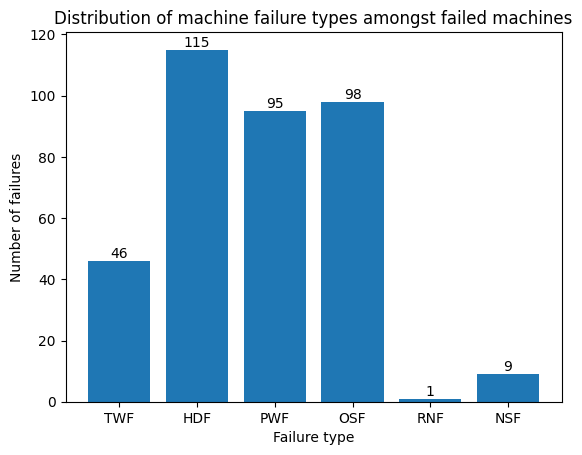

In [148]:
## Initialisation
failure_type2 = ["TWF", "HDF", "PWF", "OSF", "RNF", "NSF"]
failure_type2_nb = [0, 0, 0, 0, 0, 0]
has_failed = 0

## Computation of the different type of errors
for l in usable_dataset :
    if (l[8] == "1") :
        has_failed = 0
        if (l[9] == "1") :
            failure_type2_nb[0] += 1
            has_failed = 1
        if (l[10] == "1") :
            failure_type2_nb[1] += 1
            has_failed = 1
        if (l[11] == "1") :
            failure_type2_nb[2] += 1
            has_failed = 1
        if (l[12] == "1") :
            failure_type2_nb[3] += 1
            has_failed = 1
        if (l[13] == "1") :
            failure_type2_nb[4] += 1
            has_failed = 1
        if (has_failed == 0) :
            failure_type2_nb[5] += 1

## Plotting of the different error types
plt.figure(2)
plt.bar(failure_type2, failure_type2_nb)
plt.title('Distribution of machine failure types amongst failed machines')
plt.xlabel('Failure type')
plt.ylabel('Number of failures')
for i, value in enumerate(failure_type2_nb):
    plt.text(i, value+1, str(value), ha='center')
plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

_"Firstly, we observe that there are 18 random failures that did not lead to a machine failure, only 1 did lead to that.  
Secondly, there are some "Non Specific Failures", but they stay minimal compared to the specific failures."_

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [149]:
print(Data_names)

['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to use previous results to justify your response.

_"As inputs, we will use the following parameters :"_
   - Type
   - Air temperature [K]  
   - Process temperature [K]  
   - Rotational speed [rpm] 
   - Torque [Nm]  
   - Tool wear [min]  

_These are the variables that are susceptible to cause a failure, or influence in which way it can occurs as we've seen with the bar graphs that indicated use the main cause of failures._  
_"As for the outputs, we will need the following :"_ 
   - Machine working  
   - TWF
   - HDF
   - PWF
   - OSF  

_We cannot predict random failures, so we do not include it in the outputs, but we still need to know if the machine failed and what kind of failure caused it. The random failures being very sparse, and mainly not causing a machine failure, we do not need to worry about it. Additionnaly, we try to predict the fact that a machine is working in the first label, instead of looking for a failure, because if we have a specific failure, we automaticaly have a failure._  

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [150]:
## Initialisation of the values
X_1 = np.zeros((10000,6))
Y_1 = np.zeros((10000,5))
i=0
final_shape = 10000

## Extraction of the desired values and reordering in the correct tabs
for l in usable_dataset :
    if (l[2] == "M") : a = 0
    elif (l[2] == "L") : a = 1
    else : a = 2
    if (float(l[9]) + float(l[10]) + float(l[11]) + float(l[12]) <= 1) :
        X_1[i][0] = a
        X_1[i][1] = float(l[3])
        X_1[i][2] = float(l[4])
        X_1[i][3] = float(l[5])
        X_1[i][4] = float(l[6])
        X_1[i][5] = float(l[7])
        B = [abs(1.0-float(l[8])), float(l[9]) ,float(l[10]) ,float(l[11]), float(l[12])]
        Y_1[i] = B
        i+=1
    else : final_shape -= 1

## Finalisation of the Input and Output lists
X = np.zeros((final_shape,6))
Y = np.zeros((final_shape,5))
X = X_1[0:final_shape]
Y = Y_1[0:final_shape]

## Creation of the training, validation and test datasets
X_train, X_temporary, Y_train, Y_temporary = train_test_split(X, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_temporary, Y_temporary, test_size=0.5)
print("Shape of the training dataset. X : ", np.shape(X_train), " , Y : ", np.shape(Y_train))
print("Shape of the validation dataset. X : ", np.shape(X_val), " , Y : ", np.shape(Y_val))
print("Shape of the test dataset. X : ", np.shape(X_test), " , Y : ", np.shape(Y_test))

Shape of the training dataset. X :  (6983, 6)  , Y :  (6983, 5)
Shape of the validation dataset. X :  (1497, 6)  , Y :  (1497, 5)
Shape of the test dataset. X :  (1497, 6)  , Y :  (1497, 5)


**QUESTION** Code below the model architecture

In [151]:
## Function displaying the training curves
def display_training_curves(training_history):
  # display loss
  plt.plot(training_history.history['loss'],label='loss')
  plt.plot(training_history.history['val_loss'], label='val_loss')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()
  #display accuracy
  plt.plot(training_history.history['accuracy'],label='acc')
  plt.plot(training_history.history['val_accuracy'], label='val_acc')
  plt.xlabel("epoch")
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
  plt.show()

## Definition of the input layer of the model
inputs = tf.keras.Input(6) #my input layer

## Deinition of the "middle" layers of the model
x = tf.keras.layers.Dense(20, activation='relu')(inputs) #a first hidden layer with 20 neurons
x = tf.keras.layers.Dense(10, activation='relu')(x) #a second hidden layer with 10 neurons
x = tf.keras.layers.Dense(10, activation='relu')(x) #a third hidden layer with 10 neurons

## Definition of the output layer of the model
outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # my output layer, with 5 neurons, for the 5 classes

## Architecture instanciation of the model
my_mlp_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mlp_model")
my_mlp_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "my_mlp_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 6)]               0         
                                                                 
 dense_142 (Dense)           (None, 20)                140       
                                                                 
 dense_143 (Dense)           (None, 10)                210       
                                                                 
 dense_144 (Dense)           (None, 10)                110       
                                                                 
 dense_145 (Dense)           (None, 5)                 55        
                                                                 
Total params: 515
Trainable params: 515
Non-trainable params: 0
_________________________________________________________________


**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/20
70/70 [==============================] - 1s 3ms/step - loss: 3.3700 - accuracy: 0.9653 - val_loss: 0.2708 - val_accuracy: 0.9653
Epoch 2/20
70/70 [==============================] - 0s 1ms/step - loss: 0.2178 - accuracy: 0.9698 - val_loss: 0.2464 - val_accuracy: 0.9653
Epoch 3/20
70/70 [==============================] - 0s 1ms/step - loss: 0.2002 - accuracy: 0.9698 - val_loss: 0.2236 - val_accuracy: 0.9653
Epoch 4/20
70/70 [==============================] - 0s 1ms/step - loss: 0.1949 - accuracy: 0.9696 - val_loss: 0.2169 - val_accuracy: 0.9653
Epoch 5/20
70/70 [==============================] - 0s 1ms/step - loss: 0.1850 - accuracy: 0.9698 - val_loss: 0.2137 - val_accuracy: 0.9653
Epoch 6/20
70/70 [==============================] - 0s 1ms/step - loss: 0.1814 - accuracy: 0.9698 - val_loss: 0.1998 - val_accuracy: 0.9653
Epoch 7/20
70/70 [==============================] - 0s 1ms/step - loss: 0.1782 - accuracy: 0.9699 - val_loss: 0.2072 - val_accuracy: 0.9653
Epoch 8/20
70/70 [==

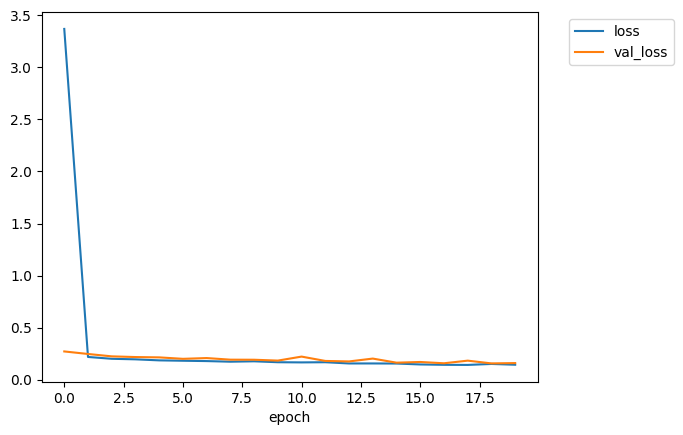

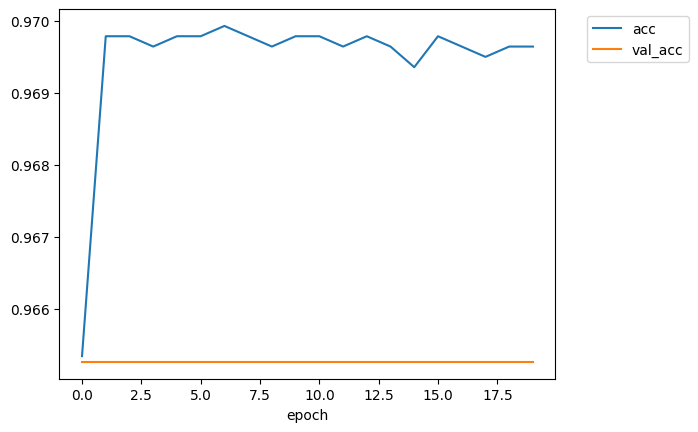

In [152]:
## Training of the model
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=20
batch_size=100
training_history = my_mlp_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

## COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mlp_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mlp_model.evaluate(X_test, Y_test, batch_size=batch_size)
print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

## Graphs allowing to directly asses the training history
display_training_curves(training_history)

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





47/47 [==============================] - 0s 913us/step
Classification report for classifier my_cnn_model:
              precision    recall  f1-score   support

  No Failure       0.97      1.00      0.99      1453
         TWF       0.00      0.00      0.00         7
         HDF       0.00      0.00      0.00        16
         PWF       0.00      0.00      0.00        12
         OSF       0.00      0.00      0.00         9

   micro avg       0.97      0.97      0.97      1497
   macro avg       0.19      0.20      0.20      1497
weighted avg       0.94      0.97      0.96      1497
 samples avg       0.97      0.97      0.97      1497




C:\Users\kevin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


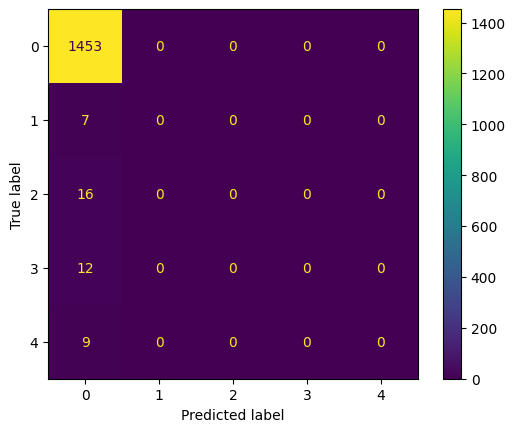

In [153]:
## Prediction of the data using the model
Y_pred_temp = my_mlp_model.predict(X_test)

## Reorganization of the datas to be used in the classification report and confusion matrix
Y_pred = np.zeros_like(Y_pred_temp)
Y_pred[np.arange(Y_pred_temp.shape[0]), np.argmax(Y_pred_temp, axis=1)] = 1
Y_test_bin  = np.zeros_like(Y_test)
Y_test_bin[np.arange(len(Y_test)), np.argmax(Y_test, axis=1)] = 1

## Prints the classification report of the model
class_names = ["No Failure", "TWF", "HDF", "PWF", "OSF"]
print(
    f"Classification report for classifier my_cnn_model:\n"
    f"{classification_report(Y_test_bin, Y_pred, target_names=class_names)}\n"
)

## Prints the confusion matrix of the model
cm = confusion_matrix(Y_test_bin.argmax(axis=1), Y_pred.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()

**ANALYSIS QUESTION** What do you observe? What can you conclude?

_Our model isn't able to learn the causes of errors, he correctly predicts when a machine is working, but as soon as there is a failure, he predicts that the machine is working. This is because there are mainly working machines in the dataset, and so he only learns what makes that a machine works._  
_So, we need to modify slightly our dataset for the model to learn correctly._

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [154]:
Y_label = np.array([np.argmax(row) for row in Y])
print('Original dataset shape %s' % Counter(Y_label))

## Under sampling of the dataset to reduce the number of machine in working conditions
rus = RandomUnderSampler(random_state=42, sampling_strategy={0:1500, 1:43, 2:106, 3:80, 4:78})
X_res, Y_res = rus.fit_resample(X, Y_label)
print('Resampled dataset shape %s' % Counter(Y_res))

## Over sampling of the dataset to augment the number of machine in failure state
sm = SMOTE(random_state=42, sampling_strategy={0:7000, 1:6500, 2:6500, 3:6500, 4:6500})
X_balanced, Y_balanced = sm.fit_resample(X_res, Y_res)
print('Resampled dataset shape %s \n' % Counter(Y_balanced))

# Convertir les étiquettes rééchantillonnées en format multilabel (one-hot encoding)
Y_balanced_multilabel = np.zeros((Y_balanced.size, Y.shape[1]))
Y_balanced_multilabel[np.arange(Y_balanced.size), Y_balanced] = 1

## Creation of the training and testing sets
X_train, X_temporary, Y_train, Y_temporary = train_test_split(X_balanced, Y_balanced_multilabel, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_temporary, Y_temporary, test_size=0.5)

print("Shape of the training dataset. X : ", np.shape(X_train), " , Y : ", np.shape(Y_train))
print("Shape of the validation dataset. X : ", np.shape(X_val), " , Y : ", np.shape(Y_val))
print("Shape of the test dataset. X : ", np.shape(X_test), " , Y : ", np.shape(Y_test))

Original dataset shape Counter({0: 9670, 2: 106, 3: 80, 4: 78, 1: 43})
Resampled dataset shape Counter({0: 1500, 2: 106, 3: 80, 4: 78, 1: 43})
Resampled dataset shape Counter({0: 7000, 1: 6500, 2: 6500, 3: 6500, 4: 6500}) 

Shape of the training dataset. X :  (23100, 6)  , Y :  (23100, 5)
Shape of the validation dataset. X :  (4950, 6)  , Y :  (4950, 5)
Shape of the test dataset. X :  (4950, 6)  , Y :  (4950, 5)


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

_In order to improve the training, we remove some of the working machines datas, and we artificially create a lot of failed machines ones. This allows to balance the number of each cases, erasing the bias that was occuring with the model._

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [155]:
## Definition of the input layer
inputs = tf.keras.Input(6)

## Definition of the "Middle" layers
x = tf.keras.layers.Dense(48, activation='relu', kernel_regularizer=l2(0.0005))(inputs) # First hidden layer with 48 neurons
x = tf.keras.layers.Dropout(0.2)(x)  # 20% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(96, activation='relu', kernel_regularizer=l2(0.0005))(x) # Second hidden layer with 96 neurons
x = tf.keras.layers.Dropout(0.3)(x)  # 30% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(192, activation='relu', kernel_regularizer=l2(0.0005))(x) # Third hidden layer with 192 neurons
x = tf.keras.layers.Dropout(0.3)(x)  # 30% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x) # Fourth hidden layer with 256 neurons
x = tf.keras.layers.Dropout(0.35)(x)  # 35% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0005))(x) # Fifth hidden layer with 256 neurons
x = tf.keras.layers.Dropout(0.35)(x)  # 35% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(192, activation='relu', kernel_regularizer=l2(0.0005))(x) # Sixth hidden layer with 192 neurons
x = tf.keras.layers.Dropout(0.3)(x)  # 30% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.0005))(x) # Seventh hidden layer with 128 neurons
x = tf.keras.layers.Dropout(0.3)(x)  # 30% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(96, activation='relu', kernel_regularizer=l2(0.0005))(x) # Eighth hidden layer with 96 neurons
x = tf.keras.layers.Dropout(0.3)(x)  # 30% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

x = tf.keras.layers.Dense(48, activation='relu', kernel_regularizer=l2(0.0005))(x) # Ninth hidden layer with 48 neurons
x = tf.keras.layers.Dropout(0.2)(x)  # 20% dropout
x = tf.keras.layers.BatchNormalization()(x)  # Normalize activations

## Definition of the outputs layers
outputs = tf.keras.layers.Dense(5, activation='softmax')(x) # Output layer, with 5 neurons, for the 5 classes

## Model architecture instanciation
my_mpl2_model = tf.keras.Model(inputs=inputs, outputs=outputs, name="my_mpl2_model")
my_mpl2_model.summary()

# (2) DEFINE THE TRAINING HYPER-PARAMETERS WITH THE "COMPILE" METHOD:
'''
(1) Set the "optimizer" [pick 'adam', 'sgd' or 'rmsprop']
(2) Set the loss [cf. lesson #3, we pick the categorical cross-entropy]
(3) Set the final performance metric to evaluate the model
'''

my_mpl2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "my_mpl2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 6)]               0         
                                                                 
 dense_146 (Dense)           (None, 48)                336       
                                                                 
 dropout_92 (Dropout)        (None, 48)                0         
                                                                 
 batch_normalization_92 (Bat  (None, 48)               192       
 chNormalization)                                                
                                                                 
 dense_147 (Dense)           (None, 96)                4704      
                                                                 
 dropout_93 (Dropout)        (None, 96)                0         
                                                     

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/40
231/231 [==============================] - 5s 7ms/step - loss: 2.2208 - accuracy: 0.3181 - val_loss: 1.6701 - val_accuracy: 0.4321
Epoch 2/40
231/231 [==============================] - 1s 6ms/step - loss: 1.6283 - accuracy: 0.5474 - val_loss: 1.9473 - val_accuracy: 0.4531
Epoch 3/40
231/231 [==============================] - 1s 5ms/step - loss: 1.3628 - accuracy: 0.6817 - val_loss: 1.6437 - val_accuracy: 0.5879
Epoch 4/40
231/231 [==============================] - 1s 5ms/step - loss: 1.2616 - accuracy: 0.7013 - val_loss: 1.1160 - val_accuracy: 0.7457
Epoch 5/40
231/231 [==============================] - 1s 5ms/step - loss: 1.1685 - accuracy: 0.7242 - val_loss: 1.0618 - val_accuracy: 0.7442
Epoch 6/40
231/231 [==============================] - 1s 5ms/step - loss: 1.0825 - accuracy: 0.7421 - val_loss: 12.7918 - val_accuracy: 0.2428
Epoch 7/40
231/231 [==============================] - 1s 5ms/step - loss: 1.0291 - accuracy: 0.7484 - val_loss: 0.8940 - val_accuracy: 0.7661
Epoch

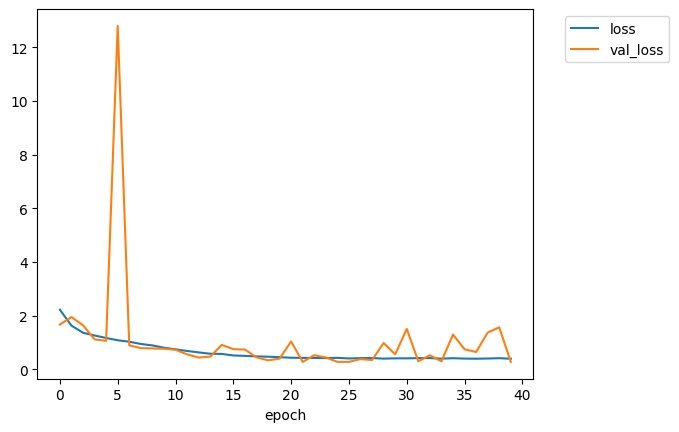

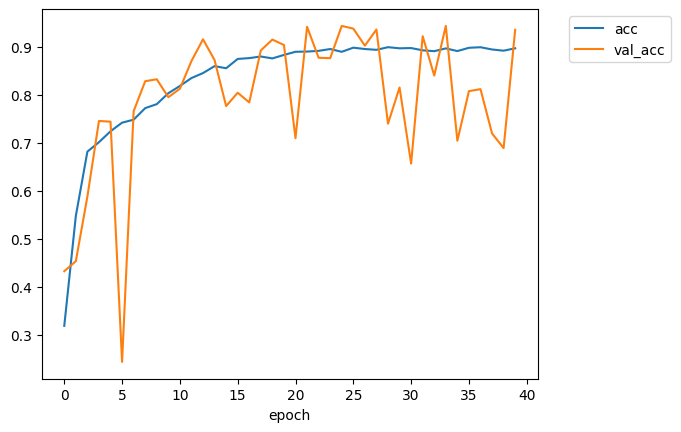

In [ ]:
# Training of the model
'''
(1) Set the number of epochs
(2) Set the size of the (mini)batch
(3) Set the training dataset ==> here, X_train with Y_train
(4) Set the validation dataset (X_val, Y_val)
'''
nb_epochs=40
batch_size=100
training_history = my_mpl2_model.fit(X_train,Y_train,
                                    validation_data=(X_val, Y_val),
                                    epochs=nb_epochs,
                                    batch_size=batch_size)

#COMPUTE THE ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = my_mpl2_model.evaluate(X_train, Y_train, batch_size=batch_size)
loss_test, acc_test = my_mpl2_model.evaluate(X_test, Y_test, batch_size=batch_size)
print("Performance on the TRAIN set, ACCURACY=",acc_train)
print("Performance on the TEST set, ACCURACY=",acc_test)

## Graphs allowing to directly asses the training history
display_training_curves(training_history)

**QUESTION** Plot the confusion matrix and the classification report

155/155 [==============================] - 0s 1ms/step
Classification report for classifier my_mpl2_model:
              precision    recall  f1-score   support

  No Failure       1.00      0.74      0.85      1005
         TWF       0.88      0.98      0.93       920
         HDF       0.87      0.96      0.92       965
         PWF       0.99      0.99      0.99      1040
         OSF       0.94      1.00      0.97      1020

   micro avg       0.93      0.93      0.93      4950
   macro avg       0.94      0.93      0.93      4950
weighted avg       0.94      0.93      0.93      4950
 samples avg       0.93      0.93      0.93      4950




INFO:tensorflow:Assets written to: C:\Users\kevin\AppData\Local\Temp\tmpxlxrc8ns\assets


INFO:tensorflow:Assets written to: C:\Users\kevin\AppData\Local\Temp\tmpxlxrc8ns\assets


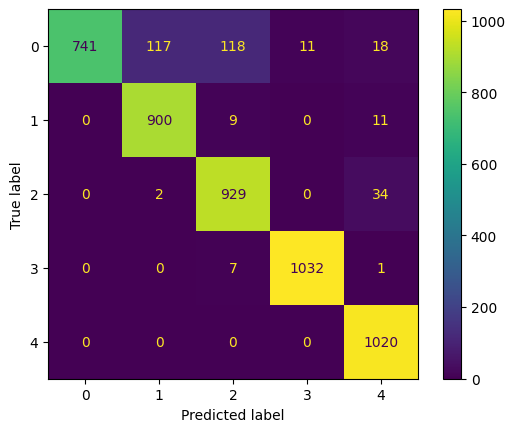

In [157]:
## Saving some data to test on the STM32
Y_pred_temp = my_mpl2_model.predict(X_test)

## Rearranging the output datas for the classification report and confusion matrix
Y_pred = np.zeros_like(Y_pred_temp)
Y_pred[np.arange(Y_pred_temp.shape[0]), np.argmax(Y_pred_temp, axis=1)] = 1
Y_test_bin  = np.zeros_like(Y_test)
Y_test_bin[np.arange(len(Y_test)), np.argmax(Y_test, axis=1)] = 1

## Prints the classification report of the model
print(
    f"Classification report for classifier my_mpl2_model:\n"
    f"{classification_report(Y_test_bin, Y_pred, target_names=class_names)}\n"
)

## Prints the confusion matrix of the model
cm = confusion_matrix(Y_test_bin.argmax(axis=1), Y_pred.argmax(axis=1))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot()

## Saving some data to test on the STM32
np.save("Machine_Failure_X_test.npy", X_test[:525])
np.save("Machine_Failure_Y_test.npy", Y_test[:525])

## Saving the model
converter = tf.lite.TFLiteConverter.from_keras_model(my_mpl2_model)
tflite_model = converter.convert()
with open('Machine_Failure_model.tflite', 'wb') as f:
  f.write(tflite_model)

**ANALYSIS QUESTION** What do you observe? What can you conclude?

_The model is quite good, but still occassionnaly does some mistakes. They stay relatively low compared to the number of datas we have, and we almost always detect failures, the main error is that the model thinks there are issues when they are none._